In [36]:
import warnings
warnings.filterwarnings("ignore")
# package
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import pdb
from keras.optimizers import SGD
# Machine learning package
from sklearn import metrics, preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import talib as ta

from keras import models
from keras import layers
from keras import optimizers
from keras.wrappers import scikit_learn

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

def scale_list(l, to_min, to_max):
    # map the number in l to [to_min, to_max]
    # step1: map the number in l to [0, 1]
    # step2: multiply the new l in step 1 by (to_max - to_min)
    def scale_number(unscaled, to_min, to_max, from_min, from_max):
        return (to_max-to_min)*(unscaled-from_min)/(from_max-from_min)+to_min

    if len(set(l)) == 1:
        return [np.floor((to_max + to_min)/2)] * len(l)
    else:
        return [scale_number(i, to_min, to_max, min(l), max(l)) for i in l]

# Get classification report    
def get_performance(report,aoc,model_score):    
    index = {'-1','1','macro avg','weighted avg'}
    index2 = {'accuracy'}
    test_1 = {key:value for key,value in report.items() if key in index}
    report2 = pd.DataFrame(test_1)
    report3 = pd.DataFrame([report['accuracy'],aoc], index=['accuracy','AUC'])
    print(report2)
    print(report3)
    return report2


In [2]:
STOCKS = ['AAPL','AXP','BA','CAT','CSCO']#,'CVX','DIS','DD','GE','GS','HD','IBM','INTC','JNJ','JPM','KO','MCD','MMM','MRK','MSFT','NKE','PFE','PG','TRV','UNH','UTX','V','VZ','WMT','XOM'

tot_stocks = len(STOCKS)

TIME_RANGE = 20 # x-axis in the image
PRICE_RANGE = 20 # y-axis in the image
VALIDTAION_CUTOFF_DATE = datetime.date(2017, 7, 1)


# split image horizontally into two sections - top and bottom sections
# we scale the price / moving avg price to the range [0 10]
# image has two parts:
# top: 
#     x : past 20 days
#     y : close price and moving average price, range:[0, 10]
# bottom:
#     x : past 20 days
#     y : close - open, range : [0, 10]

half_scale_size = int(PRICE_RANGE/2)
 
live_symbols = []
x_live = None
x_train = None
x_valid = None
y_train = []
y_valid = []


In [3]:
cnt_stock = 0

for stock in STOCKS:
    print('processing stock {} ({} / {})'.format(stock, str(cnt_stock), str(tot_stocks)))
    cnt_stock += 1

    # build image data for this stock
    # stock_data = pdr.get_data_google(stock)
    # download dataframe
    stock_data = pdr.get_data_yahoo(stock, start="2016-01-01", end="2018-01-17")

    stock_data['Symbol'] = stock
    stock_data['S_10'] = stock_data['Close'].rolling(window=3).mean()
    stock_data['MOM']= ta.MOM(stock_data.Close, timeperiod=5)
    stock_data['Date'] = stock_data.index
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], infer_datetime_format=True)
    stock_data['Date'] = stock_data['Date'].dt.date#获取data部分
    stock_data = stock_data.reset_index(drop=True)
 
    # add Moving Averages to all lists and back fill resulting first NAs to last known value
    noise_ma_smoother = 3
    stock_closes = stock_data['Close'].rolling(window = noise_ma_smoother).mean()
    stock_closes = stock_closes.fillna(method='bfill')  
    stock_closes =  list(stock_closes.values)
    stock_opens = stock_data['Open'].rolling(window = noise_ma_smoother).mean()
    stock_opens = stock_opens.fillna(method='bfill')  
    stock_opens =  list(stock_opens.values)
    stock_s10 = list(stock_data['S_10'].values)
    stock_mom = list(stock_data['MOM'].values)
    
    stock_dates = stock_data['Date'].values 
  
    close_minus_open = list(np.array(stock_closes) - np.array(stock_opens))

    # lets add a rolling average as an overlay indicator - back fill the missing
    # first five values with the first available avg price
    longer_ma_smoother = 6
    stock_closes_rolling_avg = stock_data['Close'].rolling(window = longer_ma_smoother).mean()
    stock_closes_rolling_avg = stock_closes_rolling_avg.fillna(method='bfill')  
    stock_closes_rolling_avg =  list(stock_closes_rolling_avg.values)

    for cnt in range(4, len(stock_closes)):
        print(cnt)
        if (cnt % 500 == 0): 
            print('\tfinished processing {} trading dates for stock {}'.format(str(cnt), stock))

        if (cnt >= TIME_RANGE):
            # start making images
                # np.round(x, 0) helps you to round x to the nearest EVEN value. 
                #      Thus 1.5 and 2.5 round to 2.0, -0.5 and 0.5 round to 0.0, etc.
            graph_open = list(np.round(scale_list(stock_opens[cnt-TIME_RANGE:cnt], 0, half_scale_size-1),0))
            graph_close_minus_open = list(np.round(scale_list(close_minus_open[cnt-TIME_RANGE:cnt], 0, half_scale_size-1),0))
            
            # scale both close and close MA toegher
            # since we will put the close and close MA in the same TOP part of the image, we have to scale them together.
            close_data_together = list(
                np.round(
                scale_list(
                    list(stock_closes[cnt-TIME_RANGE:cnt]) + list(stock_closes_rolling_avg[cnt-TIME_RANGE:cnt])+list(stock_s10[cnt-TIME_RANGE:cnt]),
                    0, half_scale_size-1
                ),
                0
            )
            )
            graph_close = close_data_together[0:PRICE_RANGE]
            graph_close_ma = close_data_together[PRICE_RANGE:] 

            outcome = None
            if (cnt < len(stock_closes) -1):
                outcome = 0
                if stock_closes[cnt+1] > stock_closes_rolling_avg[cnt+1]:
                    # we label the current Y (outcome） as 1 if the close price is greater 
                    # than the 6 days MA on the next trading day
                    # 0 otherwise
                    outcome = 1

            blank_matrix_close = np.zeros(shape=(half_scale_size, TIME_RANGE))
            x_ind = 0
            for ma, c in zip(graph_close_ma, graph_close):
                # you can treat the 1 and 2 are different colors
                blank_matrix_close[int(ma), x_ind] = 1 
                blank_matrix_close[int(c), x_ind] = 2  
                x_ind += 1

            # flip x scale dollars so high number is at top, low number at bottom - cosmetic, humans only
            # double colons in numpy array matrix
                # a = array([[1, 2], [3, 6], [4,5]])
                # a:
                #    1 2
                #    3 6
                #    4 5
                # since a starts with the left-top element, e.g. a[0, 0] == 1 instead of 4, we have to filp the matrix!!!!!
                # a[::-1] = array([[4, 5], [3, 6], [1, 2]]): reverse the whole array
            blank_matrix_close = blank_matrix_close[::-1]

            # store image data into matrix DATA_SIZE*DATA_SIZE
            blank_matrix_diff = np.zeros(shape=(half_scale_size, TIME_RANGE))
            x_ind = 0
            for v in graph_close_minus_open:
                blank_matrix_diff[int(v), x_ind] = 3  
                x_ind += 1
            # flip x scale so high number is atop, low number at bottom - cosmetic, humans only
            blank_matrix_diff = blank_matrix_diff[::-1]

            # stack vertically for two matrixes
            blank_matrix = np.vstack([blank_matrix_close, blank_matrix_diff]) 

            need_plot=False
            if need_plot:
                # graphed on matrix
                plt.imshow(blank_matrix)
                plt.show()

                # straight timeseries 
                plt.plot(graph_close, color='black')
                plt.show()

            if (outcome == None):
                # live data
                if x_live is None:
                    x_live =[blank_matrix]
                else:
                    x_live = np.vstack([x_live, [blank_matrix]])
                live_symbols.append(stock)

            elif (stock_dates[cnt] >= VALIDTAION_CUTOFF_DATE):
                # validation data
                if x_valid is None:
                    x_valid = [blank_matrix]
                else:
                    x_valid = np.vstack([x_valid, [blank_matrix]])
                y_valid.append(outcome)

            else:
                # training data
                if x_train is None:
                    x_train = [blank_matrix]
                else:
                    x_train = np.vstack([x_train, [blank_matrix]])
                y_train.append(outcome)

processing stock AAPL (0 / 5)
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271


111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360


x_train_mod shape: (1790, 20, 20, 1)
x_valid shape: (680, 20, 20, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 10)        1290      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 10)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 10)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 360)               0         
___________________________________________________

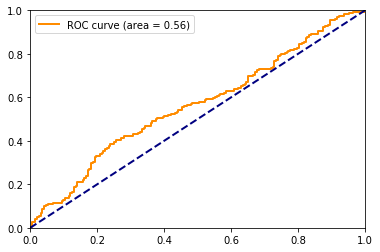

In [4]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 100
num_classes = 2
epochs = 5
 
# input image dimensions
img_rows, img_cols = TIME_RANGE, TIME_RANGE

# add fake depth channel 
x_train_mod = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)#(1790, 20, 20, 1)
# print(x_train)
# print(x_train_mod)
x_valid = x_valid.reshape(x_valid.shape[0], img_rows, img_cols, 1)
input_shape = (TIME_RANGE, TIME_RANGE, 1)

x_train_mod = x_train_mod.astype('float32')
x_valid = x_valid.astype('float32')

print('x_train_mod shape:', x_train_mod.shape)
print('x_valid shape:', x_valid.shape)

# https://keras.io/zh/utils/
# to_categorical: one-hot encoding
y_train_mod = keras.utils.to_categorical(y_train, num_classes)
y_valid_mod = keras.utils.to_categorical(y_valid, num_classes)

# ref: https://medium.freecodecamp.org/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050

model = Sequential()
model.add(Conv2D(64, (5, 5), input_shape=input_shape, activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(10, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.fit(x_train_mod, y_train_mod,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_train_mod, y_train_mod))
 

score = model.evaluate(x_train_mod, y_train_mod, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
 
predictions = model.predict(x_valid)

# run an accuracy or auc test
from sklearn.metrics import roc_curve, auc, accuracy_score
 
# balance
print('balance', np.mean(y_train_mod[:,1]))
fpr, tpr, thresholds = roc_curve(y_valid_mod[:,1], predictions[:,1])
roc_auc = auc(fpr, tpr)
print('valid auc:',roc_auc)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()

actuals = y_valid_mod[:,1]
preds = predictions[:,1]
from sklearn.metrics import accuracy_score
print ('Accuracy on all data:', accuracy_score(actuals,[1 if x >= 0.5 else 0 for x in preds]))

In [20]:
# Lets' Run with The Best Bets
threshold = 0.65
preds = predictions[:,1][predictions[:,1] >= threshold]
actuals = y_valid_mod[:,1][predictions[:,1] >= threshold]
from sklearn.metrics import accuracy_score
print ('Accuracy on higher threshold:', accuracy_score(actuals,[1 if x > 0.5 else 0 for x in preds]))
print('Returns:',len(actuals))

Accuracy on higher threshold: 0.7697841726618705
Returns: 278


valid auc: 0.563140368852459


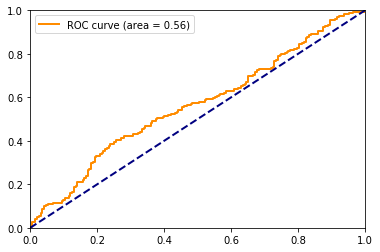

In [21]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_valid_mod[:,1], predictions[:,1])
roc_auc = auc(fpr, tpr)
print('valid auc:',roc_auc)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()

In [23]:
result = get_performance(report,roc_auc,accuracy_score(actuals,[1 if x > 0.5 else 0 for x in preds]))
print(result)

            macro avg  weighted avg
precision    0.508655      0.602155
recall       0.509520      0.579412
f1-score     0.507396      0.589383
support    680.000000    680.000000
                 0
accuracy  0.579412
AUC       0.563140
None


### Fine Tune the parameters

In [25]:
# Batch size, number of epochs
def create_model():
    # create model
    model = Sequential()
    model.add(Conv2D(64, (5, 5), input_shape=input_shape, activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(10, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# model.fit(x_train_mod, y_train_mod,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(x_train_mod, y_train_mod))
 
# 创建模型
model = scikit_learn.KerasClassifier(build_fn=create_model, verbose=0)

# 设置参数候选值
batch_size = [1000]
epochs = [5]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
learn_rate = [0.001, 0.01, 0.1]
# init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
# init_mode = ['uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']



# 创建GridSearchCV，并训练
param_grid = dict(batch_size=batch_size,epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(x_train_mod, y_train_mod)

# score = model.evaluate(x_train_mod, y_train_mod, verbose=0)
# # print('Test loss:', score[0])
# # print('Test accuracy:', score[1])
 
# predictions = model.predict(x_valid)
 
# 打印结果
print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
 
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 64)        1664      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 10)        1290      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 10)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 10)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 360)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

Best: 0.5916200995445251 using {'batch_size': 1000, 'epochs': 5}
0.591620 (0.019545) with: {'batch_size': 1000, 'epochs': 5}


In [20]:
# optimizer
def create_model(optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Conv2D(64, (5, 5), input_shape=input_shape, activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(10, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

# model.fit(x_train_mod, y_train_mod,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(x_train_mod, y_train_mod))
 
# 创建模型
model = scikit_learn.KerasClassifier(build_fn=create_model, epochs=1, batch_size=16, verbose=1)

# 设置参数候选值
optimizer = ['SGD', 'RMSprop']
learn_rate = [0.001, 0.01, 0.1]
# init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
# init_mode = ['uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']



# 创建GridSearchCV，并训练
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(x_train_mod, y_train_mod)

# score = model.evaluate(x_train_mod, y_train_mod, verbose=0)
# # print('Test loss:', score[0])
# # print('Test accuracy:', score[1])
 
# predictions = model.predict(x_valid)
 
# 打印结果
print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
 
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))




Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 16, 16, 64)        1664      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 13, 13, 10)        1290      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 10)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 6, 6, 10)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 360)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)              

Epoch 1/1
358/358 [==============================] - 0s 332us/step
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 16, 16, 64)        1664      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 13, 13, 10)        1290      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 10)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 6, 6, 10)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 360)               0         
____________________________________________________

Epoch 1/1
358/358 [==============================] - 0s 337us/step
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 16, 16, 64)        1664      
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 13, 13, 10)        1290      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 6, 6, 10)          0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 6, 6, 10)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 360)               0         
____________________________________________________

In [26]:
# weight initialization
def create_model(init_mode='uniform'):
    # create model
    model = Sequential()
    model.add(Conv2D(64, (5, 5), input_shape=input_shape, kernel_initializer=init_mode,activation='relu'))
    model.add(Conv2D(32, (3, 3), kernel_initializer=init_mode,activation='relu'))
    model.add(Conv2D(10, (2, 2), kernel_initializer=init_mode, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(50,kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(num_classes, kernel_initializer=init_mode,activation='softmax'))
    # Compile model
    optimizer = SGD(lr=1)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

# model.fit(x_train_mod, y_train_mod,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(x_train_mod, y_train_mod))
 
# 创建模型
model = scikit_learn.KerasClassifier(build_fn=create_model, epochs=1, batch_size=16, verbose=1)

# 设置参数候选值
# learn_rate = [0.001, 0.01]
# init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
# init_mode = ['uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
init_mode = ['uniform']


# 创建GridSearchCV，并训练
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train_mod, y_train_mod)

# score = model.evaluate(x_train_mod, y_train_mod, verbose=0)
# # print('Test loss:', score[0])
# # print('Test accuracy:', score[1])
 
# predictions = model.predict(x_valid)
 
# 打印结果
print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
 
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 16, 16, 64)        1664      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 13, 13, 10)        1290      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 10)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 6, 6, 10)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 360)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)              

In [27]:
# CV-test
from sklearn.model_selection import TimeSeriesSplit
cross_val = cross_val_score(model, x_valid, y_valid_mod[:,1], scoring='accuracy', cv=3)
print('CV Score =',cross_val.mean())
cross_val = cross_val_score(model, x_valid, y_valid_mod[:,1], scoring='accuracy', cv=TimeSeriesSplit(n_splits=2))
print('Time Series CV Score =',cross_val.mean())
cross_val = cross_val_score(model, x_valid, y_valid_mod[:,1], scoring='accuracy', cv=TimeSeriesSplit(max_train_size=500))
print('Time Series(max_train_size=500) CV Score =',cross_val.mean())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 16, 16, 64)        1664      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 13, 13, 10)        1290      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 10)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 6, 6, 10)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 360)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)              

Epoch 1/1
226/226 [==============================] - 0s 243us/step
Time Series CV Score = 0.747787610619469
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 16, 16, 64)        1664      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 13, 13, 10)        1290      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 10)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 6, 6, 10)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 360)               0         
___________

Epoch 1/1
113/113 [==============================] - 0s 296us/step
Time Series(max_train_size=500) CV Score = 0.6407079646017699


In [37]:
report2=get_performance(report,roc_auc,accuracy_score(actuals,[1 if x > 0.5 else 0 for x in preds]))

            macro avg  weighted avg
precision    0.508655      0.602155
recall       0.509520      0.579412
f1-score     0.507396      0.589383
support    680.000000    680.000000
                 0
accuracy  0.579412
AUC       0.563140


In [39]:
a,b,c,d,e,f=grid_result.best_score_,report2.iloc[0][1],report2.iloc[1][1],report2.iloc[2][1],roc_auc,cross_val.mean()
f1="CNN"
start="2016-01-01"
end="2018-01-17"
print("%s performs the best for my dataset." % (f1))
print("Daily "+ 'Stock: AAPL,AXP,BA,CAT,CSCO from '+start+ ' to ' +end+ "\nWith the accuracy:%.3f, precision:%.3f, recall:%.3f, f1:%.3f, auc:%.3f,CV-score:%.3f" % (a,b,c,d,e,f))


CNN performs the best for my dataset.
Daily Stock: AAPL,AXP,BA,CAT,CSCO from 2016-01-01 to 2018-01-17
With the accuracy:0.512, precision:0.602, recall:0.579, f1:0.589, auc:0.563,CV-score:0.641


### conclusion

the best parameters are: using {'batch_size': 1000, 'epochs': 5}, using{'optimizer': 'RMSprop'},using {'init_mode': 'uniform'}